# Дерево решений

Задание
1. Построить геометрическую интерпретацию критерия Джини()
2. Применить дерево решений из sklearn для задачи Titanic на kaggle (заполнив пропуски).  
Применить кросс-валидацию для подбора параметров и выбрать лучшие(например с помощью **GridSearchCV** из sklearn).  
Написать отчет о результатах.

In [194]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier
from scipy.interpolate import interp1d
from scipy.integrate import quad
from sklearn import preprocessing

%matplotlib inline

In [195]:
train = pd.read_csv('data/train.csv', sep=',')
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [196]:
test = pd.read_csv('data/test.csv', sep=',')
test_targets = pd.read_csv('data/gender_submission.csv', sep=',')
test = test.assign(Survived = test_targets.Survived)
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [197]:
print(f'train shape - {train.shape}')
print(f'test shape - {test.shape}')

train shape - (891, 12)
test shape - (418, 12)


## Бейзлайн Титаника 

In [198]:
features = ['Pclass', 'Age', 'SibSp',
       'Parch', 'Fare']

pipeline = Pipeline(steps = [('imputer', Imputer()),('scaler',StandardScaler()),('tree',DecisionTreeClassifier())])
grid = {
    'tree__criterion' : ['gini', 'entropy'],
    'tree__max_depth' : [2,5],  
}
gridsearch = GridSearchCV(pipeline, grid, cv = 3,  scoring='roc_auc')     
gridsearch.fit(np.array(train.loc[:,features]), np.array(train.Survived))
gridsearch.best_estimator_

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [199]:
gridsearch.best_score_

0.7132585562266323

In [200]:
accuracy_score(y_pred = gridsearch.predict(np.array(test[features])), y_true = test.Survived)

0.6746411483253588

# 1. Геометрическая интерпретация критерия Джини 

## Кривая Лоренца для бейзлайна

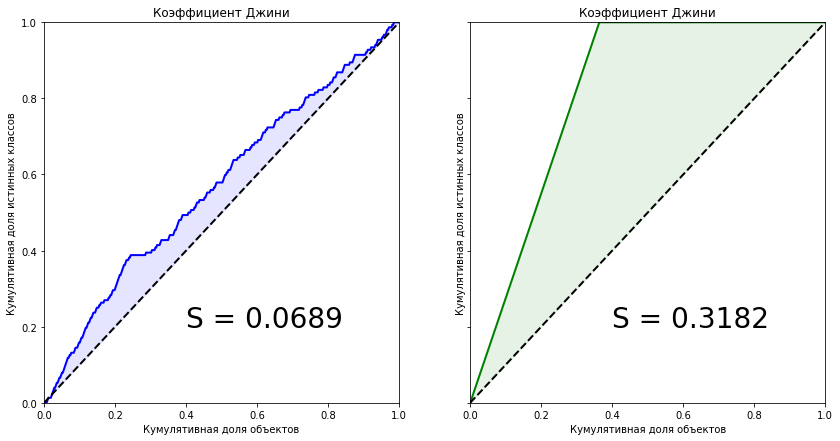

In [201]:

base_tree_pred_probs = gridsearch.predict_proba(np.array(test.loc[:,features]))
actual = test.Survived
predict = base_tree_pred_probs[:,1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]
cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)
f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=1000)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit = 1000)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue') #, marker='x'
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green') #, marker='x'
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

# 2.Улучшение бейзлайна
## Замена пропусков в данных

In [202]:
train_processed = train
test_processed = test

In [203]:
for col in train_processed.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(train_processed[col]).sum()))

PassengerId, num. NA's: 0
Survived, num. NA's: 0
Pclass, num. NA's: 0
Name, num. NA's: 0
Sex, num. NA's: 0
Age, num. NA's: 177
SibSp, num. NA's: 0
Parch, num. NA's: 0
Ticket, num. NA's: 0
Fare, num. NA's: 0
Cabin, num. NA's: 687
Embarked, num. NA's: 2


In [204]:
for col in test_processed.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(test_processed[col]).sum()))

PassengerId, num. NA's: 0
Pclass, num. NA's: 0
Name, num. NA's: 0
Sex, num. NA's: 0
Age, num. NA's: 86
SibSp, num. NA's: 0
Parch, num. NA's: 0
Ticket, num. NA's: 0
Fare, num. NA's: 1
Cabin, num. NA's: 327
Embarked, num. NA's: 0
Survived, num. NA's: 0


In [205]:
train_processed.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Используем все возможные признаки из датасета, кроме Name и Ticket

In [206]:
max_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Cabin', 'Embarked']
train_processed['Age'].fillna(train_processed['Age'].median(), inplace=True)
test_processed['Age'].fillna(test_processed['Age'].median(), inplace=True)
train_processed['Cabin'].fillna("no_value", inplace=True)
test_processed['Cabin'].fillna("no_value", inplace=True)
train_processed['Embarked'].fillna("S", inplace=True)
test_processed['Embarked'].fillna("S", inplace=True)
train_processed['Fare'].fillna(train_processed['Fare'].median(), inplace=True)
test_processed['Fare'].fillna(test_processed['Fare'].median(), inplace=True)


In [207]:
le = preprocessing.LabelEncoder()
train_processed['Sex'] = le.fit_transform(train_processed['Sex'])
train_processed['Cabin'] = le.fit_transform(train_processed['Cabin'])
train_processed['Embarked'] = le.fit_transform(train_processed['Embarked'])


test_processed['Sex'] = le.fit_transform(test_processed['Sex'])
test_processed['Cabin'] = le.fit_transform(test_processed['Cabin'])
test_processed['Embarked'] = le.fit_transform(test_processed['Embarked'])

## Подбираем лучшие параметры для дерева решений

In [208]:
tree_params = {
               'max_depth': list(range(3,10)), 
               'min_samples_leaf': list(range(3,40))}

best_tree = GridSearchCV(DecisionTreeClassifier(random_state=67), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5,
                                scoring='roc_auc')
best_tree.fit(np.array(train_processed.loc[:,max_features]), np.array(train_processed.Survived) )

Fitting 5 folds for each of 259 candidates, totalling 1295 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1295 out of 1295 | elapsed:    2.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=67,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [209]:
best_tree.best_score_

0.8568098808802024

In [210]:
accuracy_score(y_pred = best_tree.predict(np.array(test_processed[max_features])), y_true = test_processed.Survived)

0.9425837320574163

# 3. Кривая Лоренца для улучшенной модели

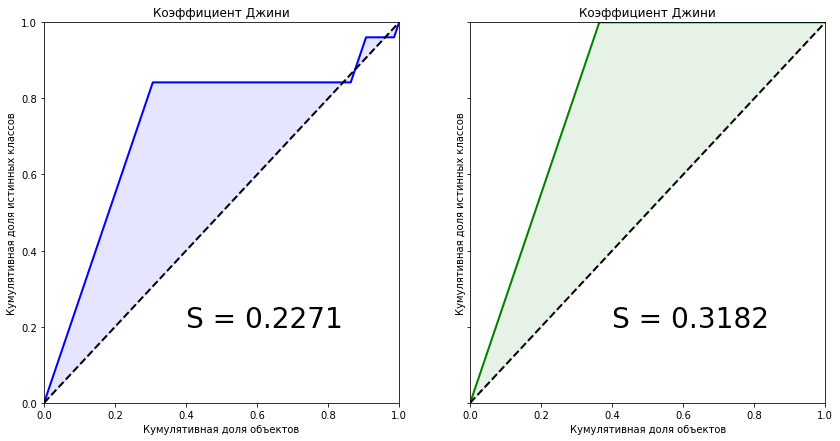

In [211]:

base_tree_pred_probs = best_tree.predict_proba(np.array(test_processed.loc[:,max_features]))
actual = test_processed.Survived
predict = base_tree_pred_probs[:,1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]
cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)
f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=1000)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit = 1000)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue') # , marker='x'
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green') #, marker='x'
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

# Улучшаем модель используя идеи с Kaggle

In [218]:
train_dataset = pd.read_csv('data/train.csv', sep=',')
test_dataset = pd.read_csv('data/test.csv', sep=',')
test_targets = pd.read_csv('data/gender_submission.csv', sep=',')
test_dataset = test_dataset.assign(Survived = test_targets.Survived)


## Очищение данных

In [219]:
# Embarked 
train_dataset["Embarked"].fillna('S', inplace=True)
test_dataset["Embarked"].fillna('S', inplace=True)
train_dataset['Port'] = train_dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_dataset['Port'] = test_dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
del train_dataset['Embarked']
del test_dataset['Embarked']
# Fare
train_dataset["Fare"].fillna(train_dataset["Fare"].median(), inplace=True)
test_dataset["Fare"].fillna(test_dataset["Fare"].median(), inplace=True)
#Age
train_dataset['Age'].fillna(train_dataset['Age'].median(), inplace=True)
test_dataset['Age'].fillna(test_dataset['Age'].median(), inplace=True)

## Добавление новых признаков

In [220]:
train_dataset['Has_Cabin'] = train_dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_dataset['Has_Cabin'] = test_dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


full_dataset = [train_dataset, test_dataset]

##family size feature
for dataset in full_dataset:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

#IsAlone from FamilySize
for dataset in full_dataset:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Get titles from the names
train_dataset['Title'] = train_dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_dataset['Title'] = test_dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in full_dataset:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for data in full_dataset:
    # classify Cabin by fare
    data['Cabin'] = data['Cabin'].fillna('X')
    data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0])
    data['Cabin'] = data['Cabin'].replace(['A', 'D', 'E', 'T'], 'M')
    data['Cabin'] = data['Cabin'].replace(['B', 'C'], 'H')
    data['Cabin'] = data['Cabin'].replace(['F', 'G'], 'L')
    data['Cabin'] = data['Cabin'].map({'X': 0, 'L': 1, 'M': 2, 'H': 3}).astype(int) 
    
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
sex_mapping = {"male": 0, "female":1}
for dataset in full_dataset:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [221]:
train_dataset.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Port,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,0,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,3,1,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,0,0,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,3,0,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,0,0,1,1,1


Удаляем признаки, которые не будем использовать

In [222]:
del train_dataset['Name']
del test_dataset['Name']

del train_dataset['SibSp']
del test_dataset['SibSp']

del train_dataset['Parch']
del test_dataset['Parch']

#del train_dataset['FamilySize']
#del test_dataset['FamilySize']

#del train_dataset['FamilySizeGroup']
#del test_dataset['FamilySizeGroup']

del train_dataset['Cabin']
del test_dataset['Cabin']

# Delete Ticket column from datasets  (No need for them in the analysis)
del train_dataset['Ticket']
del test_dataset['Ticket']

del train_dataset['Port']
del test_dataset['Port']

In [223]:
train_dataset.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,0,22.0,7.2500,0,2,0,1
1,2,1,1,1,38.0,71.2833,1,2,0,3
2,3,1,3,1,26.0,7.9250,0,1,1,2
3,4,1,1,1,35.0,53.1000,1,2,0,3
4,5,0,3,0,35.0,8.0500,0,1,1,1


In [224]:
test_dataset.head(5)

,PassengerId,Pclass,Sex,Age,Fare,Survived,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,0,34.5,7.8292,0,0,1,1,1
1,893,3,1,47.0,7.0000,1,0,2,0,3
2,894,2,0,62.0,9.6875,0,0,1,1,1
3,895,3,0,27.0,8.6625,0,0,1,1,1
4,896,3,1,22.0,12.2875,1,0,3,0,3


In [225]:
features_to_train = ['Pclass', 'Sex', 'Age', 'Fare', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']
tree_params = {
               'max_depth': list(range(3,10)), 
               'min_samples_leaf': list(range(3,40))}

new_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=67), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5,
                                scoring='roc_auc')
new_best_tree.fit(np.array(train_dataset.loc[:,features_to_train]), np.array(train_dataset.Survived) )

Fitting 5 folds for each of 259 candidates, totalling 1295 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1295 out of 1295 | elapsed:    2.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=67,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [226]:
new_best_tree.best_score_

0.8537011740308345

In [227]:
accuracy_score(y_pred = best_tree.predict(np.array(test_dataset[features_to_train])), y_true = test_dataset.Survived)

0.6363636363636364

# Кривая Лоренца для улучшенной модели

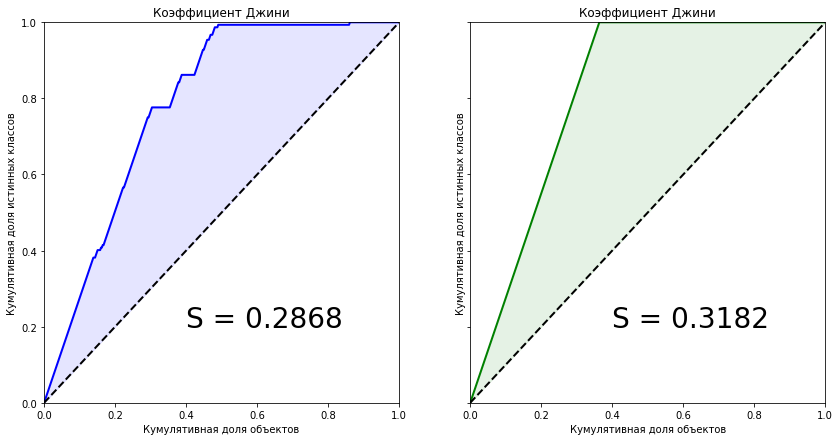

In [228]:

base_tree_pred_probs = new_best_tree.predict_proba(np.array(test_dataset.loc[:,features_to_train]))
actual = test_dataset.Survived
predict = base_tree_pred_probs[:,1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]
cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)
f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=1000)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit = 1000)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue') # , marker='x'
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green') #, marker='x'
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();